In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torchvision
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn


In [2]:
import os
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt


try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    LABS_DIR = Path ('/content/gdrive/My Drive/Labs')
except:
    LABS_DIR = Path ('C:/Labs/')

#DATA_DIR = LABS_DIR/'Data'    
DATA_DIR = LABS_DIR/'DataNoDuplicates'    

# Data augmentation and normalization for training
# for validatin we use normalization and resize (for train we also change the angle and size of the images)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


Classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Train image size: 16844
Validation image size: 5296
classes=tensor([6, 5, 3, 3, 5, 6, 2, 0, 4, 3, 3, 4, 6, 5, 4, 5])


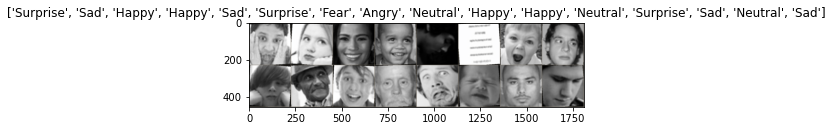

classes=tensor([2, 3, 6, 5, 3, 4, 2, 4, 0, 3, 0, 4, 2, 0, 2, 3])


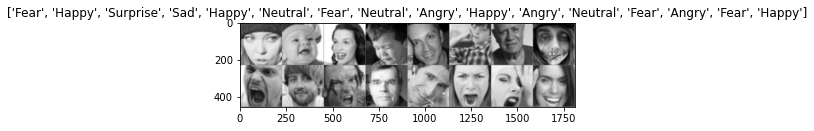

In [3]:
BATCH_SIZE = 16
SAMPLE_SIZE = None 

''' The function takes the data loader and a parameter  '''
def create_train_val_slice(image_datasets,sample_size=None,val_same_as_train=False):
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    if not sample_size: # return the whole data set
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                                      shuffle=True, num_workers=0)
                      for x in ['train', 'val']}
        return dataloaders, dataset_sizes
    
    sample_n = {x: random.sample(list(range(dataset_sizes[x])), sample_size)
                for x in ['train', 'val']}

    image_datasets_reduced = {x: torch.utils.data.Subset(image_datasets[x], sample_n[x])
                              for x in ['train', 'val']}
    
    #clone the image_datasets_reduced[train] generator for the val
    if val_same_as_train:
        image_datasets_reduced['val'] = list(image_datasets_reduced['train'])
        image_datasets_reduced['train'] = image_datasets_reduced['val']
        
    dataset_sizes = {x: len(image_datasets_reduced[x]) for x in ['train', 'val']}

    dataloaders_reduced = {x: torch.utils.data.DataLoader(image_datasets_reduced[x], batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=1) for x in ['train', 'val']}
    return dataloaders_reduced, dataset_sizes


image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes

my_data, dataset_sizes =  create_train_val_slice(image_datasets,sample_size=SAMPLE_SIZE,val_same_as_train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

def imshow(inp, title=None):
    """Imshow for Ten
    sor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  

    
    # # Get a batch of training data
inputs, classes = next(iter(my_data['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(my_data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

In [4]:
# Defining the model

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output #.detach()
    return hook

# def hook(model, input, output):
#     activation.append(output)

model = models.resnet18(pretrained=True)
# print(model.fc)
# display(model.eval())

# Changing the last FC layer
lin = model.fc
new_lin = nn.Sequential(
    nn.Linear(lin.in_features, lin.in_features),
    nn.ReLU(),
    lin
)

model.fc = new_lin
model = model.to(device)

# Adding the hooks
# model.fc.register_forward_hook(get_activation('fc2'))
model.avgpool.register_forward_hook(get_activation('avgpool'))

display(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Testing discriminator

from utils import GradientReversal

num_ftrs = model.fc[0].in_features
print(num_ftrs)

discriminator = nn.Sequential(
        GradientReversal(),
        nn.Linear(num_ftrs, 50),
        nn.ReLU(),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    ).to(device)


#discriminator(activation['avgpool'])
#model.fc(activation['avgpool'])


#.in_features

512


In [18]:
import torch.optim as optim
import torch.nn.functional as functional




lr_initial = 0.01
weight_decay = 0.1
label_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr_initial, weight_decay=weight_decay)
running_corrects = 0 


# Simulation train:
for i, (males_x, males_y) in enumerate(my_data['train']):
    if i>1:
        break; # Only run three 'epochs'
    print("Batch number :",i)
    # data['train'] contains (males_x, males_y) for every batch (so i=[1...NUM OF BATCHES]
    males_x = males_x.to(device)
    males_y = males_y.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(True):
        label_preds = model(males_x) # TODO check at the end that model archtecture still outputs the class label
        extracted_features = activation['avgpool'] # Size: torch.Size([16, 512, 1, 1])
        extracted_features = extracted_features.view(extracted_features.shape[0],-1)
        labels_pred_2 = model.fc(extracted_features)
        print("Model output and FC output are equal? ", torch.equal(label_preds,labels_pred_2))
                
        _, preds = torch.max(label_preds, 1)
        
        domain_preds = discriminator(extracted_features)
        
        print("Discriminator=",d.size(),"\n",d,"---")
        
        label_loss = label_criterion(label_preds, males_y)
        domain_loss = functional.binary_cross_entropy_with_logits(domain_preds.squeeze(),torch.ones(extracted_features.shape[0]).to(device))
        print("Domain loss =", domain_loss)
        loss = label_loss
        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

    batch_loss = loss.item() * males_x.size(0)
    running_corrects += torch.sum(preds == males_y.data)



Batch number : 0
Model output and FC output are equal?  True
Discriminator= torch.Size([16, 1]) 
 tensor([[0.2642],
        [0.2645],
        [0.2637],
        [0.2646],
        [0.3104],
        [0.2648],
        [0.2834],
        [0.2646],
        [0.2647],
        [0.4426],
        [0.2643],
        [0.4554],
        [0.2616],
        [0.2678],
        [0.2642],
        [0.4489]], device='cuda:0', grad_fn=<AddmmBackward>) ---
Domain loss = tensor(0.5685, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Batch number : 1
Model output and FC output are equal?  True
Discriminator= torch.Size([16, 1]) 
 tensor([[0.2642],
        [0.2645],
        [0.2637],
        [0.2646],
        [0.3104],
        [0.2648],
        [0.2834],
        [0.2646],
        [0.2647],
        [0.4426],
        [0.2643],
        [0.4554],
        [0.2616],
        [0.2678],
        [0.2642],
        [0.4489]], device='cuda:0', grad_fn=<AddmmBackward>) ---
Domain loss = tensor(0.5782, device='cud

In [7]:
x = activation['avgpool']
print(x.size())
y = x.view(x.shape[0],-1)
print(y.size())
model.fc(y)
discriminator(y)

torch.Size([16, 512, 1, 1])
torch.Size([16, 512])


tensor([[0.3198],
        [0.3281],
        [0.3308],
        [0.2971],
        [0.2692],
        [0.3296],
        [0.3489],
        [0.3054],
        [0.3226],
        [0.3462],
        [0.3437],
        [0.3434],
        [0.3130],
        [0.3325],
        [0.3077],
        [0.2243]], device='cuda:0', grad_fn=<AddmmBackward>)

In [8]:
discriminator[1]

Linear(in_features=512, out_features=50, bias=True)